In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
import datetime
from RoutePlanner.TemporalCellGrid import TemporalCellGrid
import matplotlib.pyplot as plt
from RoutePlanner.CellBox import CellBox

In [2]:
sose = nc.Dataset("data/SOSE_surface_velocity_6yearMean_2005-2010.nc")

currentPoints = pd.DataFrame({'long': sose['lon'][...].data.flatten(),
                                'lat': sose['lat'][...].data.flatten(),
                                'uC': sose['uC'][...].data.flatten(),
                                'vC': sose['vC'][...].data.flatten()})

currentPoints['time'] = ''
currentPoints['uC'] = currentPoints['uC'] * 3.6
currentPoints['vC'] = currentPoints['vC'] * 3.6
currentPoints['long'] = currentPoints['long'].apply(lambda x: x if x <= 180 else x - 360)

print(currentPoints)

            long        lat        uC        vC time
0       0.083333 -77.874969       NaN       NaN     
1       0.250000 -77.874969       NaN       NaN     
2       0.416667 -77.874969       NaN       NaN     
3       0.583333 -77.874969       NaN       NaN     
4       0.750000 -77.874969       NaN       NaN     
...          ...        ...       ...       ...  ...
691195 -0.750000 -24.708300  0.002377 -0.122380     
691196 -0.583313 -24.708300  0.002553 -0.119374     
691197 -0.416656 -24.708300  0.002715 -0.116243     
691198 -0.250000 -24.708300  0.002877 -0.112676     
691199 -0.083313 -24.708300  0.002877 -0.108961     

[691200 rows x 5 columns]


In [3]:
modis_ips = pd.read_csv('Modis_1km.csv')
modis_ips = modis_ips.rename(columns ={'0':'long', '1':'lat', '2':'time', '3':'iceArea', '4':'cloud'})
modis_ips['iceArea'] = modis_ips['iceArea'] * 0.1

modis_ips = modis_ips[modis_ips.cloud != 1]
print(modis_ips)

          Unnamed: 0       long        lat        time  iceArea  cloud
155              155 -63.639404 -59.998535  19-02-2017      0.5      0
177              177 -63.446045 -59.998535  19-02-2017      0.5      0
178              178 -63.437256 -59.998535  19-02-2017      0.5      0
180              180 -63.419678 -59.998535  19-02-2017      0.5      0
181              181 -63.410889 -59.998535  19-02-2017      0.6      0
...              ...        ...        ...         ...      ...    ...
14243203    14243203 -10.043701 -79.993652  19-02-2017      0.5      0
14243204    14243204 -10.034912 -79.993652  19-02-2017      0.5      0
14243205    14243205 -10.026123 -79.993652  19-02-2017      0.5      0
14243206    14243206 -10.017334 -79.993652  19-02-2017      0.5      0
14243207    14243207 -10.008545 -79.993652  19-02-2017      0.4      0

[8449828 rows x 6 columns]


In [4]:
latMin = -80
latMax = -60
longMin = -65
longMax = -10

cellWidth = 5
cellHeight = 2.5

modis_grid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight, j_grid=True)
modis_grid.addIcePoints(modis_ips)
modis_grid.addCurrentPoints(currentPoints)

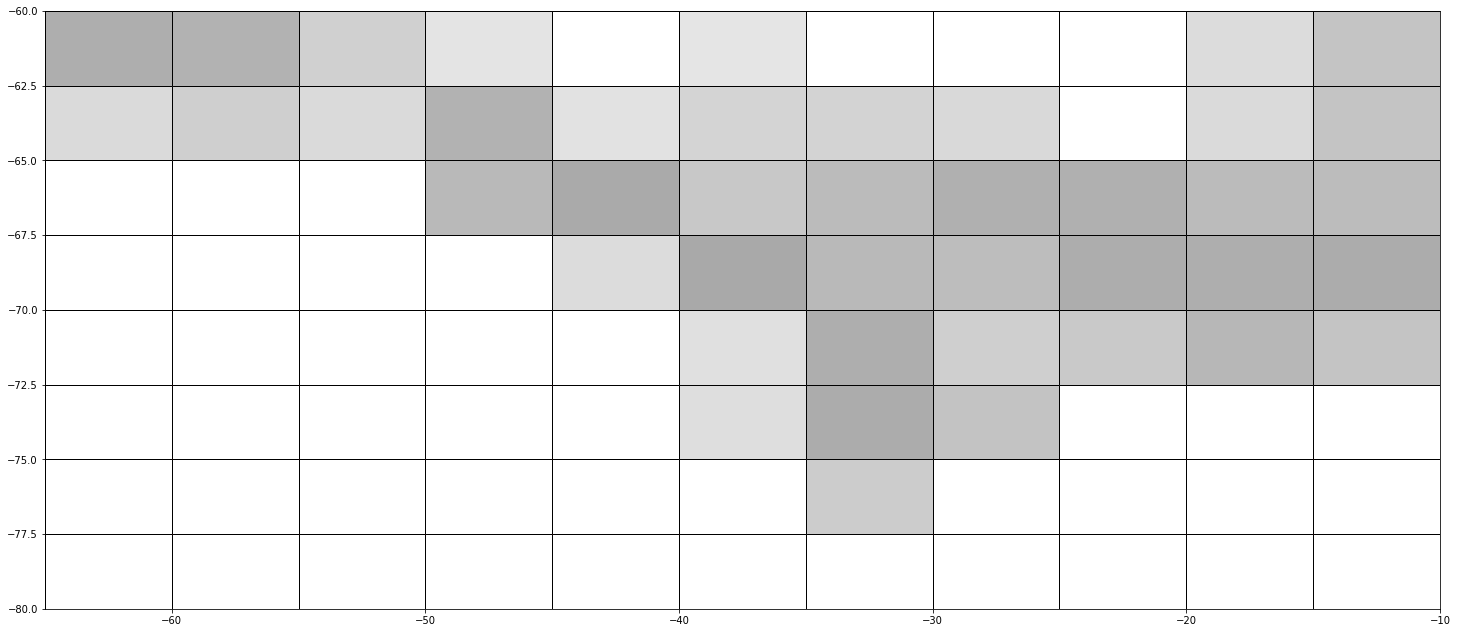

In [5]:
modis_grid.plot()

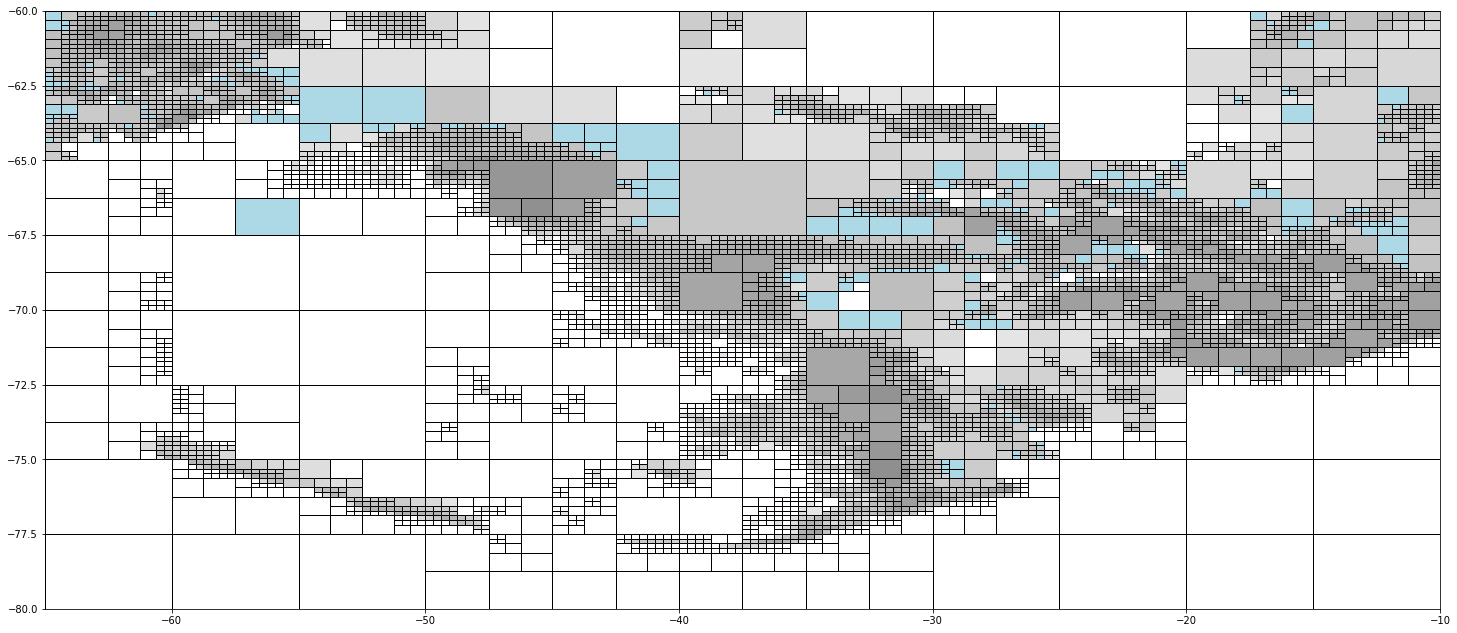

In [6]:
splittingPercentage = 0.35 # thershold
splitMinProp = 0.3 # lowerbound
splitMaxProp = 1.0 # upperbound

modis_grid.iterativeSplit(4, splittingPercentage, splitMinProp, splitMaxProp)
modis_grid.plot()

In [11]:
iceThershold = 0.8
cellsOverBound = []

for cellBox in modis_grid.cellBoxes:
    if isinstance(cellBox, CellBox):
        if cellBox.iceArea() >= iceThershold:
            cellsOverBound.append(cellBox)
        
print(len(cellsOverBound))

1176


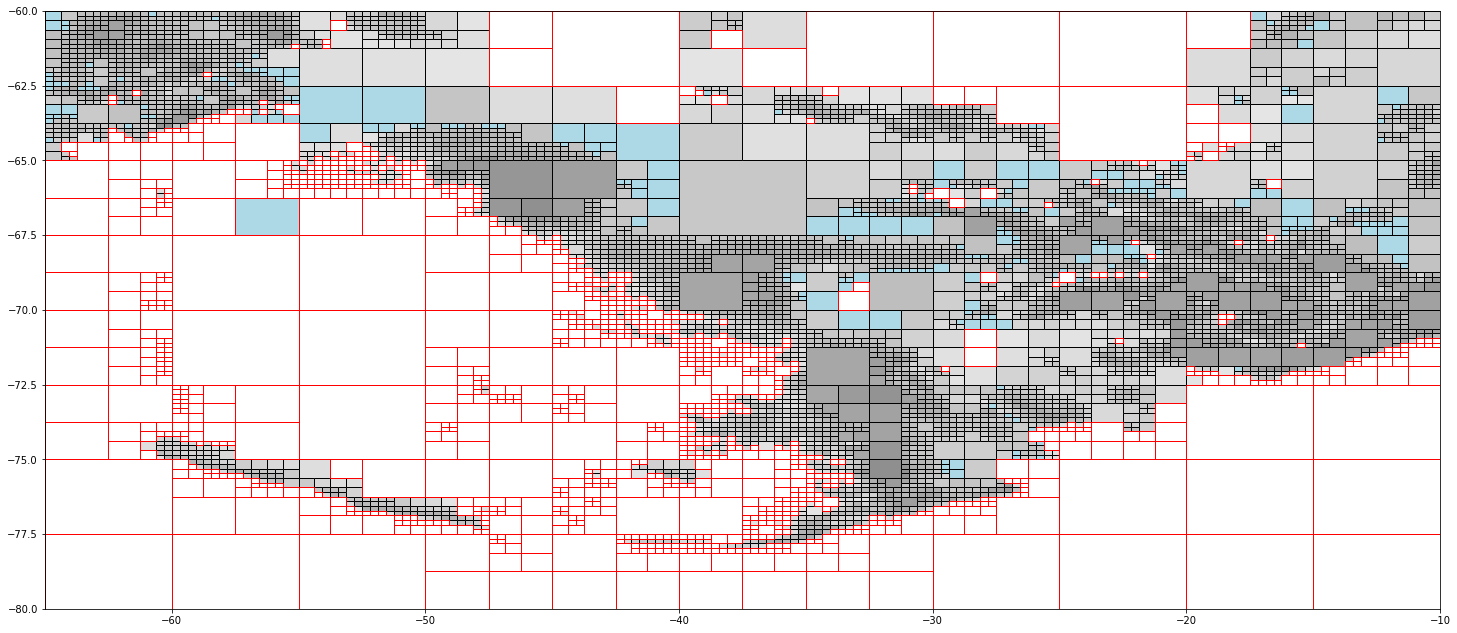

In [12]:
modis_grid.plot(highlightCellBoxes = cellsOverBound)

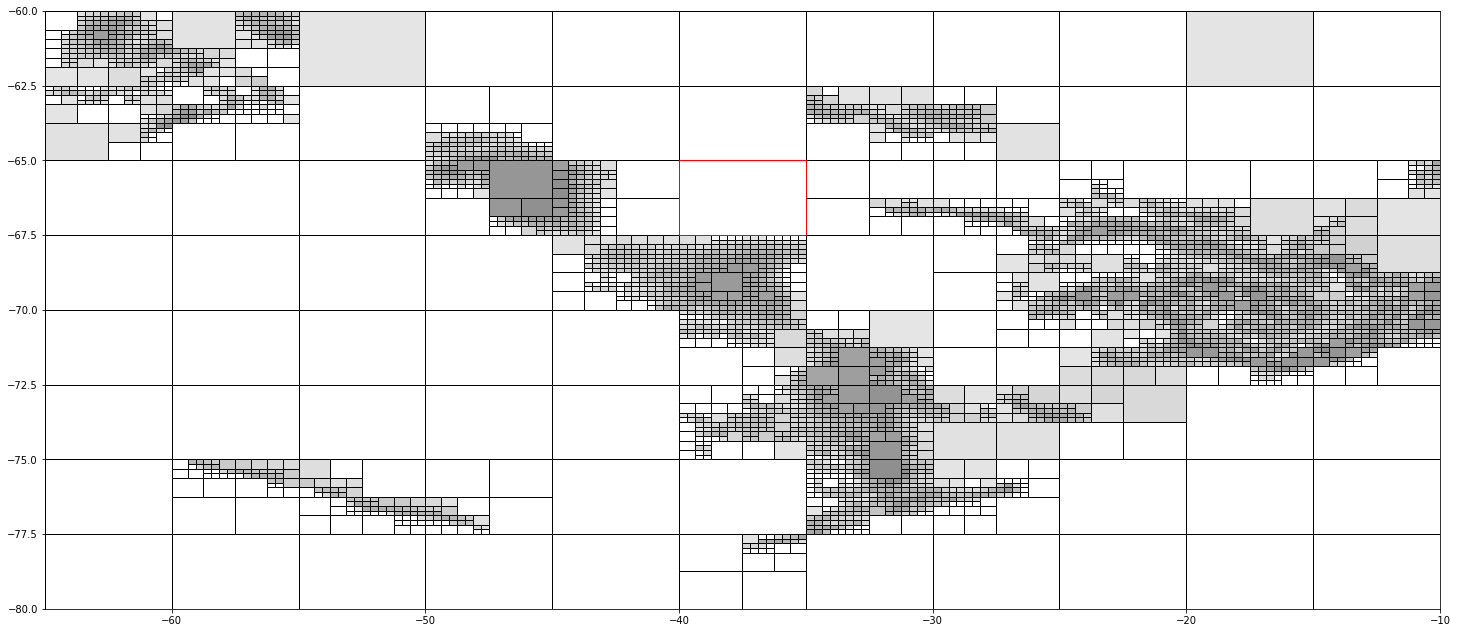

In [55]:
cellBox = modis_grid.getCellBox(-39, -66)[0]
modis_grid.plot(highlightCellBoxes = {cellBox})

In [40]:
icePoints = cellBox.getIcePoints()
print(icePoints['iceArea'].mean())

0.570754716981132


In [41]:
print(icePoints[icePoints.iceArea > splittingPercentage].shape[0] / icePoints.shape[0])

1.0
